In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm

from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from matplotlib import pyplot as plt
import itertools

from torchvision.models import vgg16,VGG16_Weights, resnet101,ResNet101_Weights
import torch.nn as nn

In [2]:
#### Config Values ###

IMG_SHAPE = (224,224,3)
BATCH_SIZE = 128
EPOCHS = 40
SHUFFLE = True
SEED = 42
CLASSES =['cats'] # for OC-CNN
CLASSES_T =['unknown','cat','dog'] # for BoN-CNN
CLASSES_B =['wild','cat','dog'] # for Bon test
TRAIN_PATH = r"C:\Users\asiclab06\Datasets\afhq\train"
TEST_PATH =  r"C:\Users\asiclab06\Datasets\afhq\val"

In [3]:
## Define Dataset

class ImageDataset(Dataset):
    def __init__(self,root,classes,target_size:tuple,shuffle=False,**kwargs):
        super().__init__()
        self.root=  root
        self.classes = [str(c) for c in classes]
        self.target_size = target_size if not type(classes) is int else (target_size,target_size)
        self.shuffle = shuffle        

        self._load_data()
        self._set_index_array()     
        self._set_shuffle()
    
        # kwargs
        self.samples = kwargs.pop('samples',None)
        if self.samples is not None:
            self._sampling_data()

    def _sampling_data(self):
        s = np.random.choice(self.__len__()-self.samples,1).item() if self.shuffle else 0
        e = self.samples
        self.data = self.data[s:e+s]
        self.label = self.label[s:e+s]

    def _load_data(self):
        self.data = []
        self.label = []

        for i,cla in enumerate(self.classes):
            sub_dir = os.path.join(self.root,cla)
            if not os.path.exists(sub_dir):
                print(f'Not found images in "{cla}" directory.')
                continue
            sub_files = os.listdir(sub_dir)
            self.data.extend([os.path.join(sub_dir,sub_file) for sub_file in sub_files])
            l=len(sub_files)
            self.label.extend([i for _ in range(l)])
            print(f'Found {l} images in "{cla}" directory.')

        self.data = np.array(self.data) 
        self.label = np.array(self.label)
        
    def _set_index_array(self):
        self.index_array = np.arange(self.__len__())
        if self.shuffle:
            self.index_array = np.random.permutation(self.__len__())

    def _set_shuffle(self):
        self.data = self.data[self.index_array]
        self.label = self.label[self.index_array]

    def __getitem__(self, index):
        """
            Return : PIL image, sparse label
        """
        x = Image.open(self.data[index]).convert('RGB')
        x = x.resize(self.target_size[:2],Image.Resampling.BILINEAR)
        

        return x, self.label[index]

    def __len__(self):
        return len(self.data)

class FaceClfDataset(ImageDataset):
    def __init__(self, root, classes, target_size: tuple, shuffle=False, transform=None, class_mode=None, **kwargs):
        super().__init__(root, classes, target_size, shuffle, **kwargs)
        # transform
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

        self.allow_class_modes =  ["categorical","sparse",None]

        if class_mode is not None:
            self.class_mode = class_mode
        else:
            self.class_mode = self.allow_class_modes[0]

    def _class_mode(self,y):
        if self.class_mode == self.allow_class_modes[0]:
            return self._to_categorical_class(y)
        elif self.class_mode == self.allow_class_modes[1]:
            return torch.tensor(y,dtype=torch.long)

    def _to_categorical_class(self,y):
        temp = torch.zeros((len(self.classes),),dtype=torch.long)
        temp[y] = 1
        return temp 

    def categorical2sparse(y:torch.Tensor):
        return torch.argmax(y,1)

    def __getitem__(self, index):
        x,y = super().__getitem__(index)
        return self.transform(x),self._class_mode(y)

    def get_sample(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()    

def get_train_dataset(imgs_folder):
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    ds = ImageFolder(imgs_folder, train_transform)
    class_num = ds[-1][1] + 1 # tuple[tensor, label] label + 1
    return ds, class_num


In [4]:
## train, val set
train_dataset = FaceClfDataset(TRAIN_PATH,CLASSES_T,(IMG_SHAPE),SHUFFLE,class_mode='categorical')
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

test_dataset = FaceClfDataset(TEST_PATH,CLASSES_B,(IMG_SHAPE),False,class_mode='sparse')
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)


Not found images in "unknown" directory.
Found 5153 images in "cat" directory.
Found 4739 images in "dog" directory.
Found 500 images in "wild" directory.
Found 500 images in "cat" directory.
Found 500 images in "dog" directory.


In [5]:
## utills 

def wrap_generator(generator):
    while True:
        x,y = next(iter(generator))
        zeros = torch.zeros_like(y) + torch.Tensor([1.,0.,0.]) # add fake label
        y = torch.concat([y,zeros], axis=0)
        yield x,y

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,cm_proba=True):
    if cm_proba:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

def plot_confusion_matrix_detail(cm,classes):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_confusion_matrix(cm,classes)
    plt.subplot(122)
    plot_confusion_matrix(cm,classes,cm_proba=False)
    
def sample_from_derectory(base_path=TEST_PATH,labels=CLASSES_T): # func only this file
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    samples = []
    for ax in axes.ravel():
        label = np.random.choice(os.listdir(base_path))
        i = np.where(np.array(labels)==label)[0]
        img = np.random.choice(os.listdir(os.path.join(base_path, label)))
        img = Image.open(os.path.join(base_path, label) + "/" + img) # os.path.join
        img = img.resize(IMG_SHAPE[:2],resample=Image.Resampling.NEAREST)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label+" "+str(i))  
        samples.append(np.array(img))
    
    return np.array(samples)

def plot_result(samples,preds,true_label=None,labels=CLASSES_B):
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    
    for i,ax in enumerate(axes.ravel()):
        label = labels[preds[i]]
        l = preds[i]
        img = Image.fromarray(samples[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("P : "+label+" "+str(l))  

class VerboseExecution(nn.Module):
    def __init__(self, model: nn.Module,permute = True):
        super().__init__()
        self.model = model
        self.layer_output = []

        def trans(tensor:torch.Tensor):
            try:
                return tensor.permute(0,2,3,1).data.numpy()
            except:
                return tensor.data.numpy()
        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: {output.shape}")
            )
            layer.register_forward_hook(
                lambda layer, input, output: self.layer_output.append([layer.__name__,(trans(output) if permute else output)])
            )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.model(x)
        return x

class ConfusionMatrix:
    def __init__(self,classes = None):
        self.cm = None

        if classes is not None:
            self.classes = classes
            self.n_classes = len(classes)

    def get_conf_matrix(self,actual,pred):
        if self.classes is None:
            self.classes = torch.unique(actual)
            self.n_classes = len(self.classes)
        conf_matrix = torch.zeros((self.n_classes, self.n_classes), dtype=torch.int32)
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                conf_matrix[i, j] = torch.sum((actual == self.classes[i]) & (pred == self.classes[j]))

        return conf_matrix

    def update(self,actual,pred):

        curr_cm = self.get_conf_matrix(actual,pred)
        if self.cm is not None:
            self.cm += curr_cm
        else:
            self.cm = curr_cm

    def get_acc(self):
        _sum = 0
        tp = 0
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                _sum += self.cm[i,j]
                if i == j:
                    tp += self.cm[i,j]
        return tp / _sum
        
    def get_result(self):
        return self.cm
    

In [8]:
## models 

def get_vgg16(n_classes,device = torch.device('cuda:0')):
    vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in vgg.parameters():
        param.requires_grad = False

    # clf.add_module(str(clf.__len__()),
    #     nn.Linear(in_features=4096, out_features=n_classes, bias=True))
    clf = nn.Sequential(
        nn.Linear(in_features=4096, out_features=512, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=False),
    )
    return nn.Sequential(vgg.features,nn.Flatten(),vgg.classifier[:1]).to(device),clf.to(device)

def get_resnet101(n_classes,device = torch.device('cuda:0')):
    resnet = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    for param in resnet.parameters():
        param.requires_grad = False

    clf = nn.Sequential(
        nn.Linear(in_features=2048, out_features=512, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=False),
    )
    return nn.Sequential(*[_ for _ in resnet.children()][:-1],nn.Flatten()).to(device),clf.to(device)

class BoNet(nn.Module):
    def __init__(self,n_classes,backbone:str,device):
        """
        Args: 
            n_classes : trainning classes number. ex. ['cat','dog'] => n_classes = 2
            backbone : current allow model [vgg16, resnet101] 
        """
        super().__init__()
        
        self.device = device
        self.n_classes = n_classes
        self.backbone, self.clf = self._get_backbone(backbone)
        self.b_name = backbone

        self.inm = nn.InstanceNorm1d(1,affine=False)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(4096) if self.b_name == 'vgg16' else nn.BatchNorm1d(2048)

        if self.device == torch.device('cuda:0'):
            self.cuda()
        else:
            self.cpu()
        
        a = next(self.backbone.parameters()).device
        print(f"Model device: {a}")
    
    def _get_backbone(self,b):
        return eval(f'get_{b}(self.n_classes,"{self.device}")')

    def forward(self,x):
        x = self.backbone(x)
        x = self.relu(self.bn(x))
        
        if self.training:
            unk_vector = torch.normal(0.,0.01,x.shape,device=self.device)
            x = x.view(-1,1,4096) # 4096, 2048
            x = self.inm(x)
            x = x.view(-1,4096) # 4096, 2048
            x = torch.vstack([x,unk_vector])
            x = self.relu(x)
        else :
            x = x

        x = self.clf(x)

        return x

    def fit(self,
        train_generator,
        epochs,
        lr,
        device,
        val_generator=None
        ):
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(self.clf.parameters(),lr=lr)
        
        for ep in range(epochs):
            train_loss = 0.
            self.train()
            i=0
            cm = ConfusionMatrix(range(self.n_classes+1))
            for x,y in tqdm(train_generator):
                z = torch.zeros((self.n_classes+1,)) # add fake label
                z[0] = 1

                zeros = torch.zeros_like(y) + z
                y = torch.concat([y,zeros], axis=0)
                x = x.to(device)
                y = y.to(device)

                pred = self.forward(x)
                loss = criterion(pred,y)
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                cm.update(torch.argmax(y,1),torch.argmax(pred,1))
                train_loss += loss.item()
                i += 1

            print(f"train loss : {train_loss/i} train acc : {cm.get_acc()}")


    def predict(self,test_generator):
        cm = ConfusionMatrix(range(self.n_classes+1))
        self.eval()
        for x,y in tqdm(test_generator):
            x = x.to(self.device)
            y = y.to(self.device)

            pred = torch.argmax(torch.softmax(self.forward(x),1),1)
            cm.update(y,pred)
            
        return cm.get_result()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
c = BoNet(2,'vgg16',device)


Model device: cuda:0


In [9]:
## BoN train

# train_dataset = FaceClfDataset(r"data\train",['unkown','cats','dogs'],(IMG_SHAPE),SHUFFLE,class_mode='categorical')
# train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

# test_dataset = FaceClfDataset(r'data\test',['wild','cats','dogs'],(IMG_SHAPE),False,class_mode='sparse')
# test_loader = DataLoader(test_dataset,BATCH_SIZE,False)

c.fit(train_loader,40,1e-4,device)


100%|██████████| 78/78 [01:27<00:00,  1.13s/it]


train loss : 0.593068200808305 train acc : 0.5468560457229614


100%|██████████| 78/78 [00:51<00:00,  1.51it/s]


train loss : 0.5414862640393086 train acc : 0.9257986545562744


100%|██████████| 78/78 [00:51<00:00,  1.51it/s]


train loss : 0.5209773350984622 train acc : 0.9987363815307617


100%|██████████| 78/78 [00:51<00:00,  1.52it/s]


train loss : 0.4846454931375308 train acc : 0.9984835982322693


100%|██████████| 78/78 [00:51<00:00,  1.51it/s]


train loss : 0.4293799480566612 train acc : 0.998079240322113


100%|██████████| 78/78 [00:51<00:00,  1.50it/s]


train loss : 0.3802312494088442 train acc : 0.9982814192771912


100%|██████████| 78/78 [00:52<00:00,  1.48it/s]


train loss : 0.31716245107161695 train acc : 0.9979276061058044


100%|██████████| 78/78 [00:54<00:00,  1.42it/s]


train loss : 0.25059723529296046 train acc : 0.9986857771873474


100%|██████████| 78/78 [00:55<00:00,  1.41it/s]


train loss : 0.1899123753492649 train acc : 0.9988374710083008


100%|██████████| 78/78 [00:54<00:00,  1.42it/s]


train loss : 0.1466050527225702 train acc : 0.9989891052246094


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.11734021712954228 train acc : 0.9990901947021484


100%|██████████| 78/78 [00:54<00:00,  1.44it/s]


train loss : 0.09016969866859607 train acc : 0.9992923736572266


100%|██████████| 78/78 [00:52<00:00,  1.48it/s]


train loss : 0.07657018657296132 train acc : 0.9994440078735352


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.053486603909196 train acc : 0.9997472763061523


100%|██████████| 78/78 [00:52<00:00,  1.50it/s]


train loss : 0.0539827731748422 train acc : 0.9996461868286133


100%|██████████| 78/78 [00:52<00:00,  1.48it/s]


train loss : 0.0592111372269499 train acc : 0.9993934631347656


100%|██████████| 78/78 [00:52<00:00,  1.47it/s]


train loss : 0.043749828106508806 train acc : 0.9996967315673828


100%|██████████| 78/78 [00:52<00:00,  1.48it/s]


train loss : 0.028170628664203178 train acc : 0.9998483657836914


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.03963571717628302 train acc : 0.9996461868286133


100%|██████████| 78/78 [00:54<00:00,  1.44it/s]


train loss : 0.038460733536153265 train acc : 0.9996967315673828


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.04618127400485369 train acc : 0.9996967315673828


100%|██████████| 78/78 [00:53<00:00,  1.45it/s]


train loss : 0.043195091283474214 train acc : 0.9999494552612305


100%|██████████| 78/78 [00:54<00:00,  1.44it/s]


train loss : 0.02945336016515891 train acc : 0.9998483657836914


100%|██████████| 78/78 [00:53<00:00,  1.47it/s]


train loss : 0.01476357476069377 train acc : 1.0


100%|██████████| 78/78 [00:52<00:00,  1.49it/s]


train loss : 0.025888627347273704 train acc : 0.9997472763061523


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.016957102259859826 train acc : 0.9998989105224609


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.01065584050061611 train acc : 1.0


100%|██████████| 78/78 [00:55<00:00,  1.42it/s]


train loss : 0.00898334306354324 train acc : 0.9998989105224609


100%|██████████| 78/78 [00:53<00:00,  1.45it/s]


train loss : 0.016787799170766123 train acc : 0.9998483657836914


100%|██████████| 78/78 [00:53<00:00,  1.47it/s]


train loss : 0.0096801130566746 train acc : 0.9999494552612305


100%|██████████| 78/78 [00:51<00:00,  1.52it/s]


train loss : 0.013155484357132362 train acc : 0.9998483657836914


100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


train loss : 0.011192081734920159 train acc : 0.9998989105224609


100%|██████████| 78/78 [00:56<00:00,  1.37it/s]


train loss : 0.008280773306838594 train acc : 0.9998483657836914


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


train loss : 0.018283709704589386 train acc : 0.9999494552612305


100%|██████████| 78/78 [00:57<00:00,  1.35it/s]


train loss : 0.017694806405462515 train acc : 0.9997472763061523


100%|██████████| 78/78 [00:58<00:00,  1.34it/s]


train loss : 0.010614000010089232 train acc : 0.9999494552612305


100%|██████████| 78/78 [00:57<00:00,  1.36it/s]


train loss : 0.009597669295871105 train acc : 0.9998989105224609


100%|██████████| 78/78 [00:55<00:00,  1.39it/s]


train loss : 0.01320940595215712 train acc : 0.9998483657836914


100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


train loss : 0.0068912532849189564 train acc : 0.9999494552612305


100%|██████████| 78/78 [00:53<00:00,  1.45it/s]

train loss : 0.007250028411642863 train acc : 0.9999494552612305


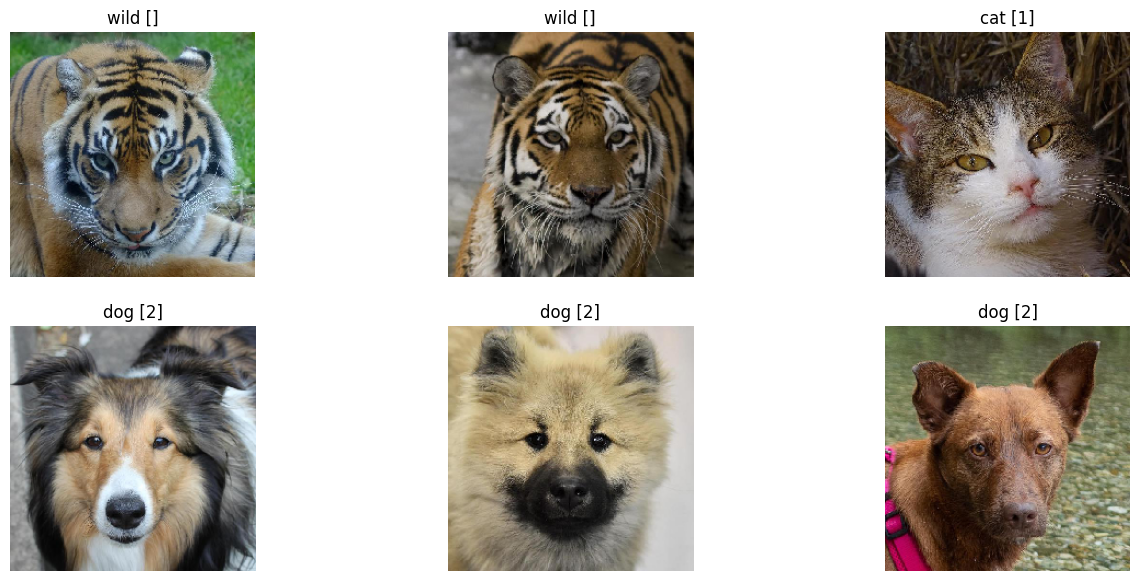

In [10]:
samples = sample_from_derectory()

In [11]:
c.eval()
inp = torch.from_numpy(samples/255)
inp = inp.permute(0,3,1,2).float().to('cuda:0')
inp = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(inp)
preds = torch.softmax(c(inp),1)
preds = torch.argmax(preds,1)
preds

tensor([0, 0, 1, 2, 2, 2], device='cuda:0')

In [12]:
re = c.predict(test_loader)

100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


In [13]:
re

tensor([[436,  39,  25],
        [  4, 496,   0],
        [  5,   0, 495]], dtype=torch.int32)

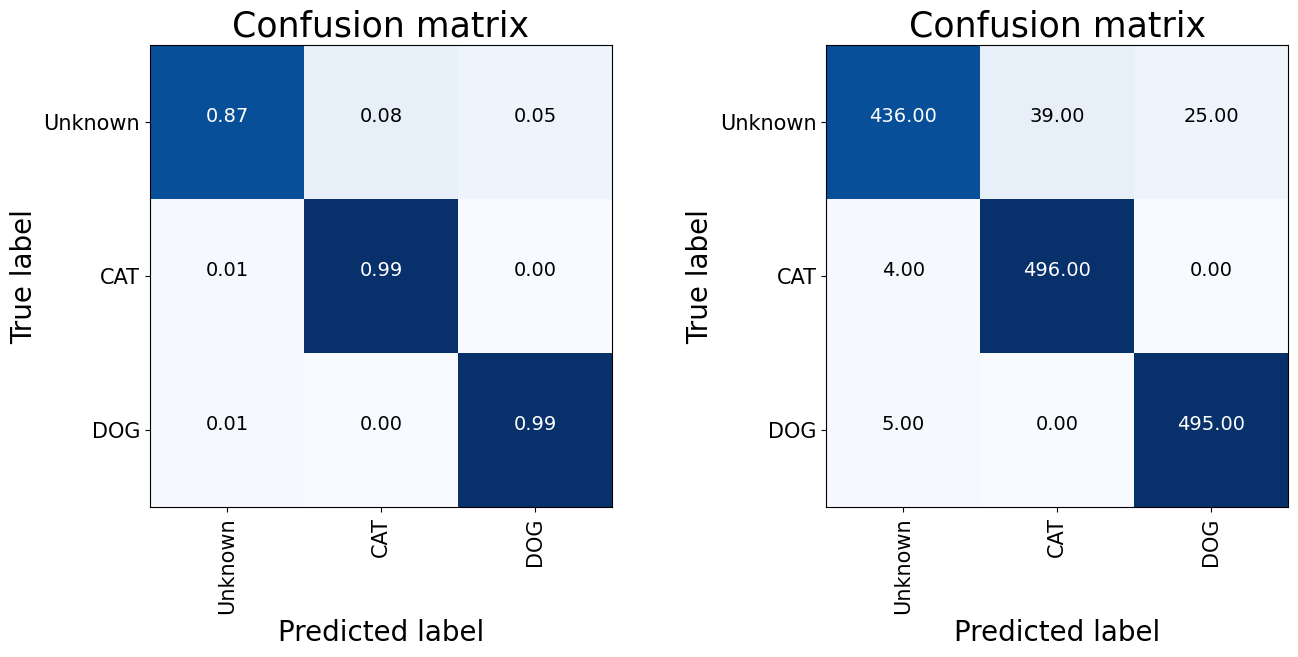

In [14]:
plot_confusion_matrix_detail(re.numpy(), classes=['Unknown','CAT','DOG'])
plt.show()

In [15]:
def classfication_report(cm,keys = ['unknown','cat','dog']):
    assert not type(cm) is list , Exception('keys type error, not support list type')

    print(np.sum(np.sum(cm)))
    targets = len(keys)
    margin = 3
    first_width = max(9,*[len(k) for k in keys])
    
    # todo: no yame
    margins = [first_width+margin+len('precision'),len('recall')+margin,len('f1-score')+margin]
    print(f"{'precision':>{margins[0]+1}} {'recall':>{margins[1]+3}} {'f1-score':>{margins[2]+3}}")
    margins = [m - first_width for m in margins]
    
    # macro
    macro_pre = 0.
    macro_re = 0.
    macro_f1 = 0.
    for target in range(targets):
        precision = cm[target,target] / sum(cm[:,target])
        recall = cm[target,target] / sum(cm[target,:])
        f1 = 2*(1/(1/recall + 1/precision))
        print(f"{keys[target]:>{first_width}s} {precision:>{margins[0]}.4f} {recall:>{sum(margins[:2])}.4f} {f1:>{sum(margins[:])}.4f}")
        macro_pre+=precision
        macro_re+=recall
        macro_f1+=f1
    print()
    print(f"{'macro avg':>{first_width+margins[1]}s} {macro_pre/targets:>{margins[0]}.4f} {macro_re/targets:>{sum(margins[:2])}.4f} {macro_f1/targets:>{sum(margins[:])}.4f}")
    
    # micro
    TP = sum(np.diag(cm))
    FP = np.sum(cm, axis=0) - np.diag(cm)
    FN = np.sum(cm, axis=1) - np.diag(cm)
    acc = TP/sum(sum(cm))
    micro_pre = np.sum(TP) / (np.sum(TP) + np.sum(FP))
    micro_re = np.sum(TP) / (np.sum(TP) + np.sum(FN))
    micro_f1 = 2 * micro_pre * micro_re / (micro_pre + micro_re)
    
    print(f"{'micro avg':>{first_width+margins[1]}s} {micro_pre:>{margins[0]}.4f} {micro_re:>{sum(margins[:2])}.4f} {micro_f1:>{sum(margins[:])}.4f}")
    print(f"{'accuarcy':>{first_width+margins[1]}s} {'':>{margins[0]}s} {'':>{sum(margins[:2])}s} {acc:>{sum(margins[:])}.4f}")
        # todo : support pass
classfication_report(re.numpy())

1500
             precision       recall       f1-score
  unknown       0.9798       0.8720         0.9228
      cat       0.9271       0.9920         0.9585
      dog       0.9519       0.9900         0.9706

macro avg       0.9529       0.9513         0.9506
micro avg       0.9513       0.9513         0.9513
 accuarcy                                   0.9513


In [31]:
# face job
from torch.utils.data import random_split

train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

ids = range(8632) # vgg
test_uk = ids[:3]
train_ids = ids[3:]

class_train = ['unknown','1','2']
class_test = ['0','1','2']

train_dataset = FaceClfDataset(r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs",class_train,
               IMG_SHAPE,False,train_transform,class_mode='categorical')

test_dataset = FaceClfDataset(r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs",class_test,
               IMG_SHAPE,False,train_transform,class_mode='sparse')

train_size = int(0.8 * train_dataset.__len__())
test_size = train_dataset.__len__()- train_size
train_dataset, val_dataset = random_split(train_dataset,[train_size,test_size])


Not found images in "unknown" directory.
Found 205 images in "1" directory.
Found 385 images in "2" directory.
Found 315 images in "0" directory.
Found 205 images in "1" directory.
Found 385 images in "2" directory.


In [37]:
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)
test_loader = DataLoader(test_dataset,BATCH_SIZE,SHUFFLE)
val_loader = DataLoader(val_dataset,BATCH_SIZE,SHUFFLE)
c = BoNet(len(class_train)-1,'vgg16',device)
c.fit(train_loader,120,1e-3,device)

Model device: cuda:0


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


train loss : 0.9518396109342575 train acc : 0.36546608805656433


100%|██████████| 4/4 [00:02<00:00,  1.42it/s]


train loss : 0.725981131196022 train acc : 0.4438559412956238


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


train loss : 0.6447698473930359 train acc : 0.4713982939720154


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


train loss : 0.621849775314331 train acc : 0.4756355881690979


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


train loss : 0.6029099375009537 train acc : 0.4830508530139923


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


train loss : 0.5843632519245148 train acc : 0.49046608805656433


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


train loss : 0.5741476714611053 train acc : 0.4936440587043762


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


train loss : 0.5658573657274246 train acc : 0.49788135290145874


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


train loss : 0.5605376660823822 train acc : 0.49894067645072937


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


train loss : 0.5598897486925125 train acc : 0.4957627058029175


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


train loss : 0.5583234876394272 train acc : 0.49894067645072937


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.5567420125007629 train acc : 0.5


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.5587794929742813 train acc : 0.49788135290145874


100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


train loss : 0.5510653853416443 train acc : 0.5


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


train loss : 0.5494576692581177 train acc : 0.5


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


train loss : 0.5477945953607559 train acc : 0.5010592937469482


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


train loss : 0.5486369878053665 train acc : 0.5836864113807678


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


train loss : 0.5452055484056473 train acc : 0.5010592937469482


100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


train loss : 0.5415754467248917 train acc : 0.5052965879440308


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


train loss : 0.5400440841913223 train acc : 0.7552965879440308


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


train loss : 0.5365037322044373 train acc : 0.9046609997749329


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


train loss : 0.5340149104595184 train acc : 0.7913135886192322


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


train loss : 0.531437337398529 train acc : 0.9819915294647217


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


train loss : 0.5285317748785019 train acc : 0.9947034120559692


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


train loss : 0.519896537065506 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.516426220536232 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.5130942314863205 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


train loss : 0.5028703361749649 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.4944397807121277 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


train loss : 0.48116442561149597 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


train loss : 0.482221357524395 train acc : 0.9947034120559692


100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


train loss : 0.5517984852194786 train acc : 0.9872881174087524


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.5096459239721298 train acc : 0.9883474707603455


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.5404741168022156 train acc : 0.5656779408454895


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.5377669036388397 train acc : 0.49894067645072937


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.5082046389579773 train acc : 0.7669491767883301


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


train loss : 0.5377056896686554 train acc : 0.9894067645072937


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.49345405399799347 train acc : 0.9936440587043762


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


train loss : 0.5059313699603081 train acc : 0.992584764957428


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.4837544858455658 train acc : 0.9947034120559692


100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


train loss : 0.4531704783439636 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


train loss : 0.4675305411219597 train acc : 0.991525411605835


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.4418170675635338 train acc : 0.9957627058029175


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


train loss : 0.4165506511926651 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


train loss : 0.4310903623700142 train acc : 0.992584764957428


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


train loss : 0.46184076368808746 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.40490932017564774 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


train loss : 0.4011223018169403 train acc : 0.9947034120559692


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.39381425827741623 train acc : 0.992584764957428


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


train loss : 0.3896677494049072 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.35382968932390213 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.39024142175912857 train acc : 0.991525411605835


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


train loss : 0.44380438327789307 train acc : 0.929025411605835


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.4419762045145035 train acc : 0.9332627058029175


100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


train loss : 0.3722788691520691 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.34691737592220306 train acc : 0.9957627058029175


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


train loss : 0.32201291620731354 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.34410852938890457 train acc : 0.9904661178588867


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.3244546949863434 train acc : 0.9957627058029175


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


train loss : 0.37805505841970444 train acc : 0.9957627058029175


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


train loss : 0.32755351811647415 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


train loss : 0.29518114775419235 train acc : 0.9936440587043762


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.2967735305428505 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


train loss : 0.2718200534582138 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


train loss : 0.24348082765936852 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


train loss : 0.23308363929390907 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.22937491536140442 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


train loss : 0.206479512155056 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


train loss : 0.2839190848171711 train acc : 0.992584764957428


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


train loss : 0.26516052335500717 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


train loss : 0.27512743324041367 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.2759380489587784 train acc : 0.9957627058029175


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


train loss : 0.24667590856552124 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


train loss : 0.2820741832256317 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


train loss : 0.21320346742868423 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.21018404513597488 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


train loss : 0.1817622147500515 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


train loss : 0.19922419264912605 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


train loss : 0.19350722059607506 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


train loss : 0.1608659289777279 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


train loss : 0.134983591735363 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


train loss : 0.14655455015599728 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


train loss : 0.11847394146025181 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


train loss : 0.12763725221157074 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


train loss : 0.11916512437164783 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


train loss : 0.09821714274585247 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


train loss : 0.10198092274367809 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


train loss : 0.13940978236496449 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


train loss : 0.11540167033672333 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


train loss : 0.10741770267486572 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


train loss : 0.082994619384408 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


train loss : 0.09919256158173084 train acc : 0.9947034120559692


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


train loss : 0.15194979682564735 train acc : 0.991525411605835


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


train loss : 0.16394835337996483 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


train loss : 0.17606189474463463 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


train loss : 0.1250837128609419 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


train loss : 0.1036530863493681 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


train loss : 0.06730617862194777 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


train loss : 0.10422443598508835 train acc : 0.9968220591545105


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


train loss : 0.07796070165932178 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.10035108588635921 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


train loss : 0.06925213150680065 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


train loss : 0.05682712234556675 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.059868449345231056 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


train loss : 0.049327604472637177 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.04463949427008629 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


train loss : 0.06342054437845945 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


train loss : 0.050602893345057964 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


train loss : 0.06162273231893778 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


train loss : 0.05962212476879358 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


train loss : 0.04712365474551916 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


train loss : 0.03613381274044514 train acc : 1.0


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


train loss : 0.0309800636023283 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


train loss : 0.028650768101215363 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


train loss : 0.02933174278587103 train acc : 0.9989407062530518


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


train loss : 0.05112268403172493 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


train loss : 0.0347258523106575 train acc : 1.0


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


train loss : 0.14312229678034782 train acc : 0.9957627058029175


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


train loss : 0.08704389492049813 train acc : 0.9978813529014587


100%|██████████| 4/4 [00:16<00:00,  4.22s/it]

train loss : 0.0643601343035698 train acc : 0.9989407062530518


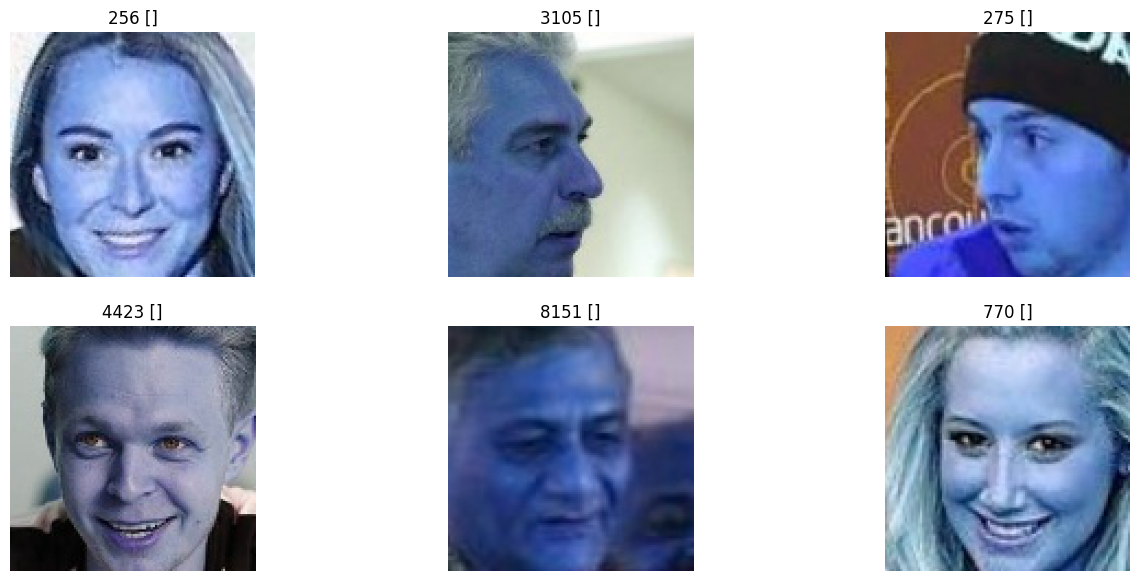

In [38]:
samples = sample_from_derectory(r"C:\Users\asiclab06\Datasets\faces_vgg_112x112\imgs",['unknown','1','2'])

In [39]:
c.eval()
inp = torch.from_numpy(samples/255)
inp = inp.permute(0,3,1,2).float().to('cuda:0')
inp = transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])(inp)
preds = torch.softmax(c(inp),1)
preds = torch.argmax(preds,1)
preds

tensor([0, 0, 1, 2, 1, 0], device='cuda:0')

100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


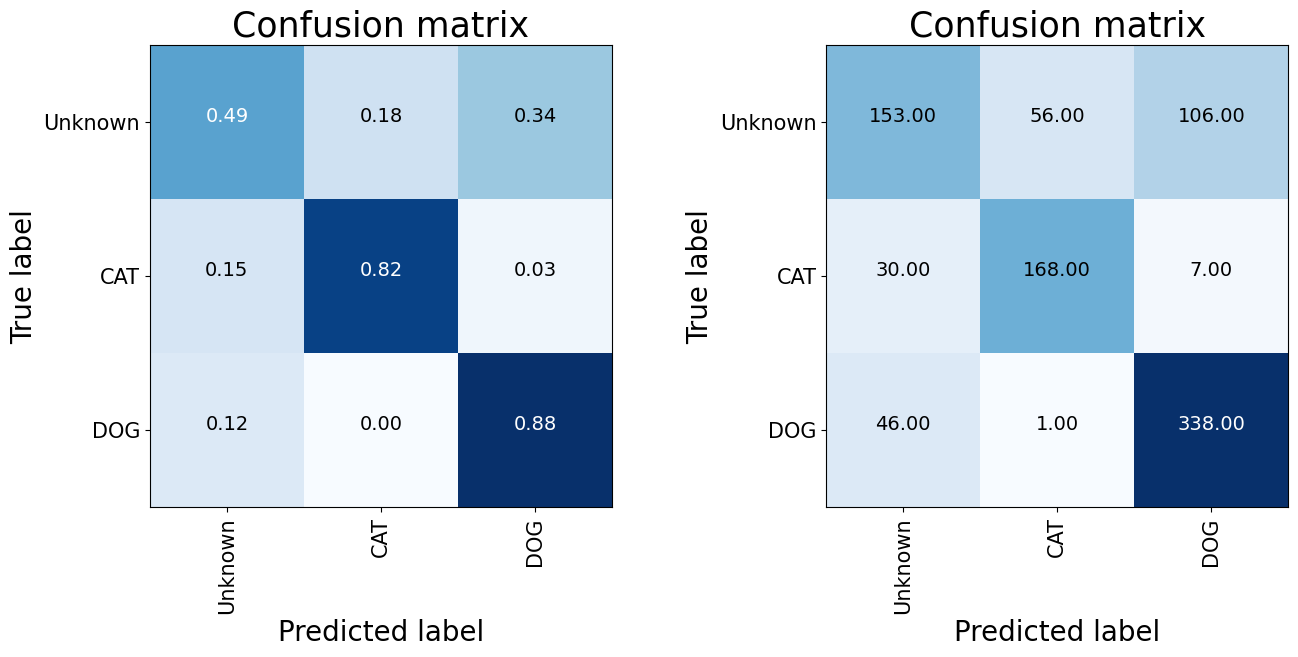

In [40]:
re = c.predict(test_loader)
plot_confusion_matrix_detail(re.numpy(), classes=['Unknown','CAT','DOG'])
plt.show()